# Introduction to neural network classification with TensorFlow

 A classification is where you try to cassify something as one thing or another

 * Binary classificaion
 * Multiclass classification
 * Multilabel classification

# Creating data to view and fit

In [1]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import datetime
import numpy as np
import itertools

# Make 1000 examples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

2023-12-18 19:04:41.232770: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-18 19:04:41.232808: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-18 19:04:41.233752: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-18 19:04:41.239396: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-18 19:04:42.006788: W tensorflow/compiler/tf2

In [2]:
# Check out features
X[:10]

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       [-0.39373073,  0.69288277],
       [ 0.44220765, -0.89672343],
       [-0.47964637,  0.67643477],
       [-0.01364836,  0.80334872],
       [ 0.77151327,  0.14775959],
       [-0.16932234, -0.79345575],
       [-0.1214858 ,  1.02150905]])

In [3]:
# Check the labels
y[:10]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0])

In [4]:
import pandas as pd
circles = pd.DataFrame({"X0":X[:, 0], "X1":X[:, 1], "label":y})
circles

,X0,X1,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


In [5]:
def plot_decision_boundary(model, X, y):
    """
    Plots the decision boundary created by a model predicting on X.
    This function has been adapted from two phenomenal resources:
    1. CS231n - https://cs231n.github.io/neural-networks-case-study/
    2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
    """
    # Define the axis boundaries of the plot and create a meshgrid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    # Create X values (we're going to predict on all of these)
    # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html
    x_in = np.c_[xx.ravel(), yy.ravel()]

    # Make predictions using the trained model
    y_pred = model.predict(x_in)

    # Check for multi-class
    # checks the final dimension of the model's output shape, if this is > (greater than) 1, it's multi-class
    if model.output_shape[-1] > 1:
        print("doing multiclass classification...")
        # We have to reshape our predictions to get them ready for plotting
        y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
    else:
        print("doing binary classifcation...")
        y_pred = np.round(np.max(y_pred, axis=1)).reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

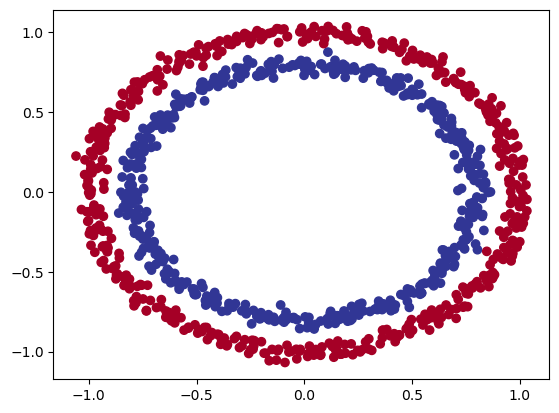

In [6]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [7]:
  X.shape, y.shape

((1000, 2), (1000,))

In [8]:
len(X), len(y)

(1000, 1000)

In [9]:
X[0], y[0]

(array([0.75424625, 0.23148074]), 1)

## Steps in modelling

The steps in modelling with TensorFloe are typically:

1. Create or import a model
2. Compile the model
3. Fit the model
4. Evaluate the model
5. Tweak
6. Evaluate

In [10]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [11]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

In [12]:
# # Set the random seed
# tf.random.set_seed(42)

# # Initialize W&B
# wandb.init(project="Classification_fundamentals", name="Dense:1:Sigmoid.SGD.E:5")

# # 1. Create a model
# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(1, activation="sigmoid")  # Add activation="sigmoid"
# ])

# # 2. Compile the model
# model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
#               optimizer=tf.keras.optimizers.SGD(),
#               metrics=["accuracy"])  # Use a list for metrics

# # Set up TensorBoard callback
# model_info = "Sigmoid.SGD.E:5"
# log_dir = "logs/fit/" + model_info + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# # 3. Fit the model with both callbacks
# model.fit(X, y, epochs=5, callbacks=[tensorboard_callback, WandbCallback()])

In [13]:
# import os
# import datetime

# # Set the random seed
# tf.random.set_seed(42)

# # Create a model
# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(1, activation="sigmoid")  # Add activation="sigmoid"
# ])

# # Compile the model
# model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
#               optimizer=tf.keras.optimizers.SGD(),
#               metrics=["accuracy"])  # Use a list for metrics

# # Specify absolute path for TensorBoard logs
# absolute_path = os.path.abspath(
#     "C:\\Users\\Kajetan\\tensorflow_fundamentals-main\\logs\\fit"
# )

# # Set up TensorBoard callback
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=absolute_path)

# # Fit the model with both callbacks
# model.fit(X, y, epochs=5, callbacks=[tensorboard_callback])


In [14]:
# Start a new TensorBoard instance
%tensorboard --logdir logs/fit

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(model=model_1, show_shapes=True)

NameError: name 'model_1' is not defined

In [ ]:
tf.random.set_seed(42)

wandb.init(project="Classification_fundamentals", name="Dense:100:10:1.Relu.Sigmoid.E:250")

model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.SGD(),
               metrics=["accuracy"])

model_into = "Dense:100:10:1.Relu.Sigmoid.E:250"
log_dir = "logs/fit" + model_info + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    profile_batch=0,  # No profiling
    write_images=True,  # Weight images
    embeddings_freq=1,
    embeddings_metadata='Dense:100:10:1.Relu.Sigmoid.E:250.tsv',
    update_freq='epoch'  # update after each epoch
)

model.fit(X, y, epochs=250, callbacks=[tensorboard_callback, WandbCallback()])

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
# SInce we're working on a binary classfication problem and our odewl is getting aroud 50% acccuracy... 
# it is preforming as
# So let's step things up a notch and add an extra layer

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Initialize W&B
wandb.init(project="Classification_fundamentals", name="Dense:1,1.Relu,Sigmoid.E:100")

# Create the model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.SGD(),
               metrics=["accuracy"])

# Set up TensorBoard callback
model_info = "Dense:1,1.Relu,Sigmoid.E:100"
log_dir = "logs/fit/" + model_info + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    profile_batch=1,
    write_images=True,
    embeddings_freq=1,
    embeddings_metadata="Dense:1,1.Relu,Sigmoid.E:100.tsv",
    update_freq="epoch"
)

# Fit the model
model_3.fit(X, y, epochs=100, verbose=0, callbacks=[tensorboard_callback, WandbCallback()])

In [ ]:
model_2.evaluate(X, y)

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
circles["label"].value_counts()

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model=model_3, show_shapes=True)

## Improving our  model

1. Create a model - we might to dd moe layers or increase the number of hidden units within a layer
2. Compiling a model - here we might to choose a different optimization function such as Adam instead of SGD.
3. Fitting a model - perhaps we might fir our model for more epochs (leave it training for longer)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# 1. Create the model (this time 3 layers)
wandb.init(project="Classification_fundamentals", name="Dense:100relu,10relu,1sigmoid.Adam.E:100")
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# 2. Compile the model
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Set up TensorBoard callback with default values
model_info = "Dense:100relu,10relu,1sigmoid.Adam.E:100"
log_dir = "logs/fit/" + model_info + datetime.datetime.now().strftime("%Y:%:m%:d-%H%:M%:S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# 3. Fit the model
history = model_3.fit(X, y, epochs=100, verbose=0, callbacks=[tensorboard_callback, WandbCallback()])

model_3.save("/home/kajetan/tensorflow_fundamentals/02_best_models_keras/model_3.keras")
history_df = pd.DataFrame(history.history)
history_df.to_csv("/home/kajetan/tensorflow_fundamentals/02_best_models_history/model_3_history.csv", index=False)

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
model_3.evaluate(X, y)

In [ ]:
metric_names = model_2.metrics_names

prefixed_metric_names_2 = [f"Model_2_{metric}" for metric in metric_names]
prefixed_metric_names_3 = [f"Model_3_{metric}" for metric in metric_names]

df = pd.DataFrame({
    "Metric": metric_names + metric_names,
    "Value": model_2.evaluate(X, y) + model_3.evaluate(X, y),
    "Model":  prefixed_metric_names_2 + prefixed_metric_names_3
})

df

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# 1. Create the model (this time 3 layers)
wandb.init(project="Classification_fundamentals", name="Dense:100relu,10relu,1sigmoid.Adam.E:30")
model_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# 2. Compile the model
model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Set up TensorBoard callback with default values
model_info = "Dense:100relu,10relu,1sigmoid.Adam.E:30"
log_dir = "logs/fit/" + model_info + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# 3. Fit the model
model_4.fit(X, y, epochs=30, verbose=0, callbacks=[tensorboard_callback, WandbCallback()])

In [ ]:
%tensorboard --logdir logs/fit

To visualize our model's predictions, let's create a function `plot_decision_boundary()`

* Take in a trained model, features (X), and labels (y)
* Create a meshgrid of the different X values
* Make predictions accros the meshgrid
* Plot the predicitoons as well as a line between zones

In [ ]:
plot_decision_boundary(model=model_3,
                      X=X,
                      y=y)

In [ ]:
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 0].max() + 0.1
    x_min, x_max, y_min, y_max

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create some regression data
X_regression = np.arange(0, 1000, 5)
y_regression = np.arange(100, 1100, 5)

# Split it into training and test sets
X_reg_train = X_regression[:150]
X_reg_test = X_regression[150:]
y_reg_train = y_regression[:150]
y_reg_test = y_regression[150:]

# Fit our model to the data
# Note: Before TensorFlow 2.7.0, this line would work
# model_3.fit(X_reg_train, y_reg_train, epochs=100)

# After TensorFlow 2.7.0, see here for more: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/278
model_3.fit(tf.expand_dims(X_reg_train, axis=-1),
            y_reg_train,
            epochs=100)

Oh wait... we compiled our model for a binary classification proble.

But... we're working on a regression problem, let's change the model to suit our data

In [ ]:
# Setup random seed
tf.random.set_seed(42)

# 1. Create the model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model, this time with a regression-specific loss function
model_3.compile(loss=tf.keras.losses.mae,
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["mae"])

model_info = "Regression.Dense:100,10,1.Adam:E:100"
log_dir = "logs/fit/" + model_info + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# 3. Fit the model
model_3.fit(tf.expand_dims(X_reg_train, axis=-1),
            y_reg_train, 
            epochs=100,
           callbacks=[tensorboard_callback])

In [ ]:
model_3.evaluate(X_reg_train, y_reg_train)

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
# Setup random seed
tf.random.set_seed(42)

# 1. Create the model
model_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model, this time with a regression-specific loss function
model_4.compile(loss=tf.keras.losses.mae,
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["mae"])

model_info = "Regression.Dense:20,10,1.Adam:E:20"
log_dir = "logs/fit/" + model_info + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# 3. Fit the model
model_4.fit(tf.expand_dims(X_reg_train, axis=-1),
            y_reg_train, 
            epochs=20,
           callbacks=[tensorboard_callback])

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True, to_file='model_4.png')


In [ ]:

# Make predictions with our trained model
y_reg_preds = model_3.predict(X_reg_test)

# Plot the model's predictions against our regression data
plt.figure(figsize=(10, 7))
plt.scatter(X_reg_train, y_reg_train, c='b', label='Training data')
plt.scatter(X_reg_test, y_reg_test, c='g', label='Testing data')
plt.scatter(X_reg_test, y_reg_preds.squeeze(), c='r', label='Predictions')
plt.legend();
     

# The missing piece: Non-linearity

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# 1. Create the model
model_5 = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation=tf.keras.activations.linear)
])

# 2. Compile the model
model_5.compile(loss="binary_crossentropy",
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               metrics=["accuracy"])

model_info = "Regression.Dense:1.Adam.E:100"
log_dir = "logs/fit/" + model_info + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

model_5.fit(X, y, epochs=100, callbacks=[tensorboard_callback])

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [ ]:
# Check the decision boundary 
plot_decision_boundary(model=model_5,
                      X=X,
                      y=y)

Let's try build our first neural network with non -lineral activation function.

In [ ]:
tf.random.set_seed(42)

# 1. Create a model with a non-linear activation
model_6 = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation=tf.keras.activations.relu),
])

# 2. Compile the model
model_6.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               metrics="accuracy")

model_info = "Classification:Dense:1.Adam,lr=0.001.E:100"
log_dir = "logs/dir" + model_info + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# 3. Fit the model
model_6.fit(X, y, epochs=100, callbacks=[tensorboard_callback])

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
# Check the decision boundary 
plot_decision_boundary(model=model_6,
                      X=X,
                      y=y)

In [ ]:
tf.random.set_seed(42)

# 1. Create a model with a non-linear activation
model_6 = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(5, activation=tf.keras.activations.relu)
])

# 2. Compile the model
model_6.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               metrics="accuracy")

model_info = "Classification:Dense:5,5.Adam,lr=0.001.E:100"
log_dir = "logs/fit" + model_info + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# 3. Fit the model
model_6.fit(X, y, epochs=100, callbacks=[tensorboard_callback])

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
tf.random.set_seed(42)

# 1. Create a model with a non-linear activation
model_7 = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(5, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_7.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               metrics="accuracy")

model_info = "Classification:Dense:5,5,1.Adam,lr=0.001.E:100"
log_dir = "logs/fit/" + model_info + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# 3. Fit the model
model_7.fit(X, y, epochs=100, callbacks=[tensorboard_callback])

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
model_7.evaluate(X, y)

In [ ]:
model_6.evaluate(X, y)

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_6, show_shapes=True)

In [ ]:
plot_model(model_7, show_shapes=True)

In [ ]:
# How do our model predicitons look?
plot_decision_boundary(model_6, X, y)

In [ ]:
plot_decision_boundary(model_7, X, y)

In [ ]:
plot_decision_boundary(model_3, X, y)

In [ ]:
# 4. Evaluate the model
model_3.evaluate(X, y)

In [ ]:
model_6.evaluate(X, y)

In [ ]:
model_7.evaluate(X, y)

In [ ]:
# Creaet a toy a tensor (similar to the data we pass into our moels)
A = tf.cast(tf.range(-10, 10), tf.float32)
A

In [ ]:
# Visualize our toy tensor
plt.plot(A);

In [ ]:
# Let's start by replicating sigmoid - sigmoid(X) = 1 / (1 + exp(-x))
def sigmoid(x):
    return 1 / (1 + tf.exp(-x))

# Use the sigmodi funciton of our toy tensor
sigmoid(A)

In [ ]:
plt.plot(sigmoid(A))

In [ ]:
def relu(x):
    return tf.maximum(x, 0)

relu(A)

In [ ]:
plt.plot(relu(A))

In [ ]:
plt.plot(tf.nn.softmax(A))

In [ ]:
tf.keras.activations.linear(A)

In [ ]:
# Does the linear activation fucntion change anything?
plt.plot(tf.keras.activations.linear(A))

In [ ]:
A == tf.keras.activations.linear(A)

## Evaluating and improving ou classification

In [ ]:
# Check how many examples we have
len(X)

In [17]:
# Split into train and test sets
X_train, y_train = X[:800], y[:800]
X_test, y_test = X[800:], y[800:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((800, 2), (800,), (200, 2), (200,))

In [18]:
import os
import datetime

# Set the random seed
tf.random.set_seed(42)

# 1. Create a model
model_8 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")  # Add activation="sigmoid"
])

# 2. Compile the model
model_8.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=["accuracy"])  # Use a list for metrics

# Specify absolute path for TensorBoard logs
absolute_path = os.path.abspath(
    "/home/kajetan/tensorflow_fundamentals/logs/fit"
)

# Set up TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=absolute_path)

# 3. Fit the model
history = model_8.fit(X, y, epochs=25, callbacks=[tensorboard_callback])
model_8.save("/home/kajetan/tensorflow_fundamentals/best_models_keras/model_8.keras")

Epoch 1/25
32/32 [==============================] - 1s 1ms/step - loss: 0.7047 - accuracy: 0.4590
Epoch 2/25
32/32 [==============================] - 0s 1ms/step - loss: 0.6960 - accuracy: 0.4670
Epoch 3/25
32/32 [==============================] - 0s 1ms/step - loss: 0.6942 - accuracy: 0.5000
Epoch 4/25
32/32 [==============================] - 0s 1ms/step - loss: 0.6936 - accuracy: 0.5000
Epoch 5/25
32/32 [==============================] - 0s 1ms/step - loss: 0.6935 - accuracy: 0.4700
Epoch 6/25
32/32 [==============================] - 0s 1ms/step - loss: 0.6937 - accuracy: 0.5000
Epoch 7/25
32/32 [==============================] - 0s 1ms/step - loss: 0.6932 - accuracy: 0.5020
Epoch 8/25
32/32 [==============================] - 0s 1ms/step - loss: 0.6933 - accuracy: 0.5000
Epoch 9/25
32/32 [==============================] - 0s 1ms/step - loss: 0.6933 - accuracy: 0.5040
Epoch 10/25
32/32 [==============================] - 0s 1ms/step - loss: 0.6934 - accuracy: 0.5000
Epoch 11/25
32/32 [

FileNotFoundError: [Errno 2] No such file or directory: '/home/kajetan/tensorflow_fundamentals/best_models_keras/model_8.keras'

In [19]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 6175), started 0:00:42 ago. (Use '!kill 6175' to kill it.)

In [20]:
# 4 Evaluate the model on the test dataset
model_8.evaluate(X_test, y_test)

7/7 [==============================] - 0s 1ms/step - loss: 0.6932 - accuracy: 0.4950


[0.6932331919670105, 0.4950000047683716]

313/313 [==============================] - 0s 824us/step
doing binary classifcation...
313/313 [==============================] - 0s 688us/step
doing binary classifcation...


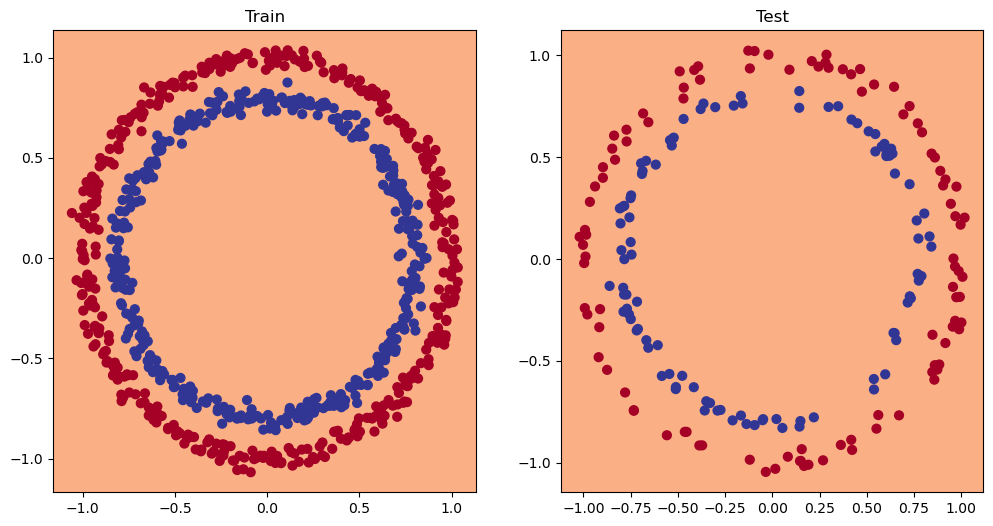

In [21]:
# Plot the decision boundaries for the training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_8, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_8, X=X_test, y=y_test)
plt.show()

In [22]:
model_8.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 4)                 12        
                                                                 
 dense_4 (Dense)             (None, 4)                 20        
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                                 
Total params: 37 (148.00 Byte)
Trainable params: 37 (148.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
# Convert the hitory object into a dataframe 
pd.DataFrame(history.history)

,loss,accuracy
0,0.704733,0.459
1,0.695962,0.467
2,0.694155,0.500
3,0.693552,0.500
4,0.693461,0.470
5,0.693667,0.500
6,0.693249,0.502
7,0.693306,0.500
8,0.693276,0.504
9,0.693378,0.500


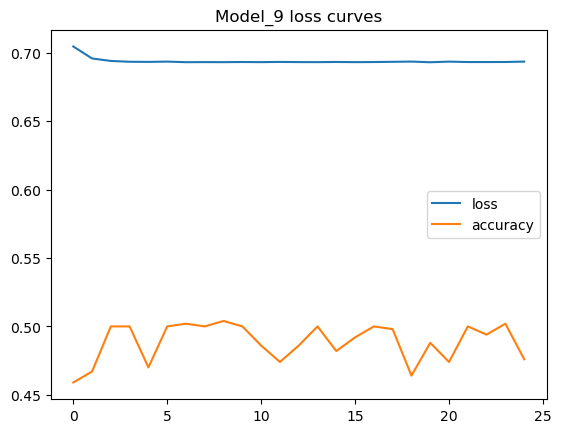

In [24]:
# plot the loss curves
pd.DataFrame(history.history).plot()
plt.title("Model_9 loss curves");

## Finding the best learning rate

TO find the ideal learnig rate (the learning rate whete the loss decreases the most during trianing) we're going to use the following steps:
* A leearning raet **callback** - you can tthink of a callback as an extra piec of functionality, you can add to you **while** its training.
* Another model (we could use the same one as above, but we're practing building 

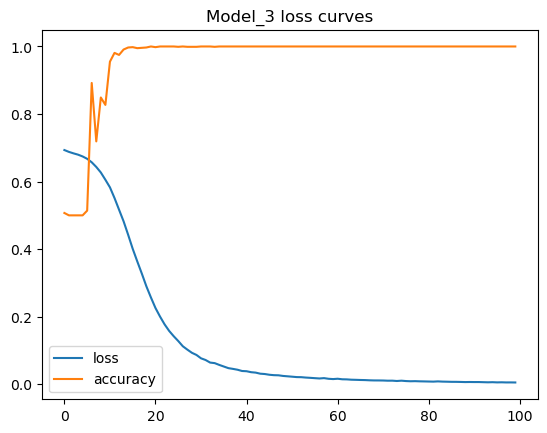

In [25]:
import pandas as pd

# Load the training history from a CSV file
loaded_model_3_history = pd.read_csv("/home/kajetan/tensorflow_fundamentals/02_best_models_history/model_3_history.csv")

# Plot the training history
loaded_model_3_history.plot()
plt.title("Model_3 loss curves")
plt.show()

In [26]:
from tensorflow.keras.models import load_model

loaded_model_3 = load_model("/home/kajetan/tensorflow_fundamentals/02_best_models_keras/model_3.keras")
loaded_model_3.evaluate(X, y)

32/32 [==============================] - 0s 894us/step - loss: 0.0047 - accuracy: 1.0000


[0.0046789757907390594, 1.0]

In [27]:
import os

tf.random.set_seed(42)

# Create a model
model_10 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_10.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

# Create a learning rate callbacks
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

absolute_path = os.path.abspath(
    "/home/kajetan/tensorflow_fundamentals/logs/fit"
)

# Set up TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=absolute_path)

# Fit the model 
history_10 = model_10.fit(X_train, 
                       y_train, 
                       epochs=100, 
                       callbacks=[lr_scheduler, tensorboard_callback])

Epoch 1/100
25/25 [==============================] - 1s 1ms/step - loss: 0.8161 - accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/100
25/25 [==============================] - 0s 1ms/step - loss: 0.8119 - accuracy: 0.5000 - lr: 1.1220e-04
Epoch 3/100
25/25 [==============================] - 0s 1ms/step - loss: 0.8076 - accuracy: 0.5025 - lr: 1.2589e-04
Epoch 4/100
25/25 [==============================] - 0s 1ms/step - loss: 0.8030 - accuracy: 0.4988 - lr: 1.4125e-04
Epoch 5/100
25/25 [==============================] - 0s 1ms/step - loss: 0.7983 - accuracy: 0.5000 - lr: 1.5849e-04
Epoch 6/100
25/25 [==============================] - 0s 1ms/step - loss: 0.7934 - accuracy: 0.4950 - lr: 1.7783e-04
Epoch 7/100
25/25 [==============================] - 0s 1ms/step - loss: 0.7879 - accuracy: 0.4938 - lr: 1.9953e-04
Epoch 8/100
25/25 [==============================] - 0s 1ms/step - loss: 0.7827 - accuracy: 0.4913 - lr: 2.2387e-04
Epoch 9/100
25/25 [==============================] - 0s 1ms/step - loss:

Epoch 73/100
25/25 [==============================] - 0s 1ms/step - loss: 0.6975 - accuracy: 0.4888 - lr: 0.3981
Epoch 74/100
25/25 [==============================] - 0s 1ms/step - loss: 0.7048 - accuracy: 0.4787 - lr: 0.4467
Epoch 75/100
25/25 [==============================] - 0s 1ms/step - loss: 0.7000 - accuracy: 0.4988 - lr: 0.5012
Epoch 76/100
25/25 [==============================] - 0s 1ms/step - loss: 0.7024 - accuracy: 0.4963 - lr: 0.5623
Epoch 77/100
25/25 [==============================] - 0s 1ms/step - loss: 0.7064 - accuracy: 0.4863 - lr: 0.6310
Epoch 78/100
25/25 [==============================] - 0s 1ms/step - loss: 0.7091 - accuracy: 0.4988 - lr: 0.7079
Epoch 79/100
25/25 [==============================] - 0s 1ms/step - loss: 0.7107 - accuracy: 0.5088 - lr: 0.7943
Epoch 80/100
25/25 [==============================] - 0s 1ms/step - loss: 0.7011 - accuracy: 0.4988 - lr: 0.8913
Epoch 81/100
25/25 [==============================] - 0s 1ms/step - loss: 0.7104 - accuracy: 0.5

<Axes: xlabel='epochs'>

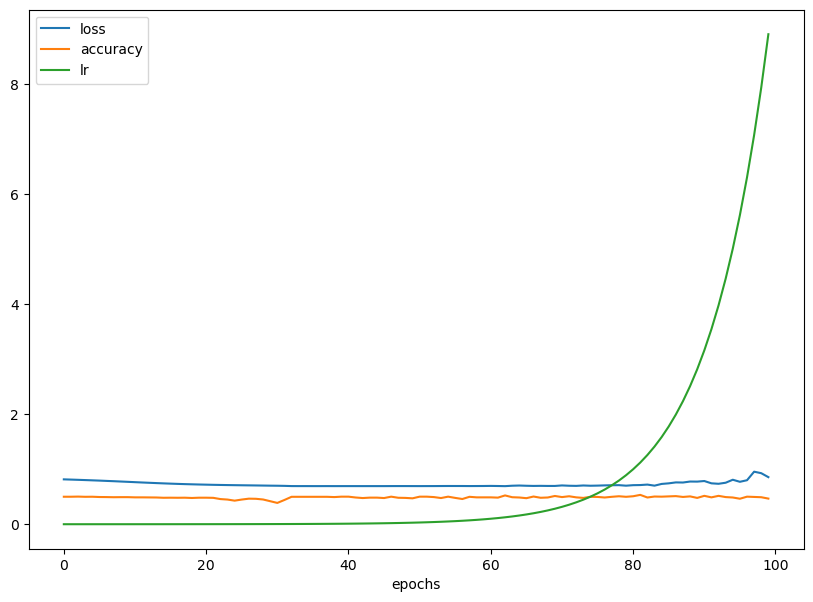

In [28]:
# Checkout the history
pd.DataFrame(history_10.history).plot(figsize=(10, 7), xlabel="epochs")

Text(0.5, 1.0, 'Learning rate vs. Loss')

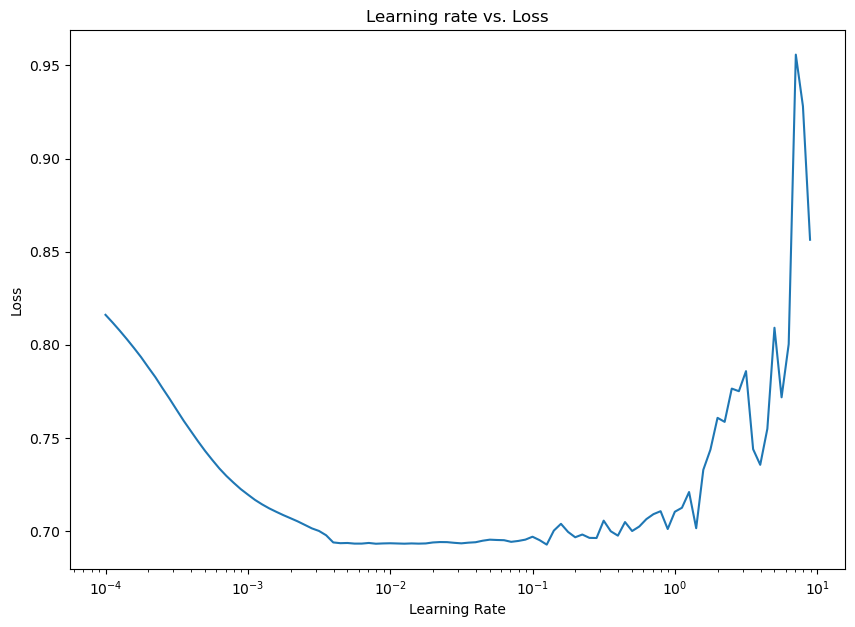

In [29]:
# Plot the learning rate versys the loss
lrs = 1e-4 * (10 ** (tf.range(100)/20))
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, history_10.history["loss"])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. Loss")

In [30]:
1e-1, 1e-2, 1e-3, 1e-4, 2e-2

(0.1, 0.01, 0.001, 0.0001, 0.02)

In [31]:
import os
tf.random.set_seed(42)

model_11 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_11.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(2e-2),
                metrics=["accuracy"])

absolute_path = os.path.abspath(
    "/home/kajetan/tensorflow_fundamentals/logs/fit"
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=absolute_path)

history_11 = model_11.fit(X_train, y_train, epochs=20, callbacks=[tensorboard_callback])

Epoch 1/20
25/25 [==============================] - 1s 1ms/step - loss: 0.6965 - accuracy: 0.4650
Epoch 2/20
25/25 [==============================] - 0s 1ms/step - loss: 0.6913 - accuracy: 0.5088
Epoch 3/20
25/25 [==============================] - 0s 1ms/step - loss: 0.6859 - accuracy: 0.5163
Epoch 4/20
25/25 [==============================] - 0s 1ms/step - loss: 0.6808 - accuracy: 0.5425
Epoch 5/20
25/25 [==============================] - 0s 1ms/step - loss: 0.6763 - accuracy: 0.5400
Epoch 6/20
25/25 [==============================] - 0s 1ms/step - loss: 0.6717 - accuracy: 0.5788
Epoch 7/20
25/25 [==============================] - 0s 1ms/step - loss: 0.6652 - accuracy: 0.6000
Epoch 8/20
25/25 [==============================] - 0s 1ms/step - loss: 0.6554 - accuracy: 0.6350
Epoch 9/20
25/25 [==============================] - 0s 1ms/step - loss: 0.6321 - accuracy: 0.6550
Epoch 10/20
25/25 [==============================] - 0s 1ms/step - loss: 0.6021 - accuracy: 0.6938
Epoch 11/20
25/25 [

<Axes: xlabel='epochs'>

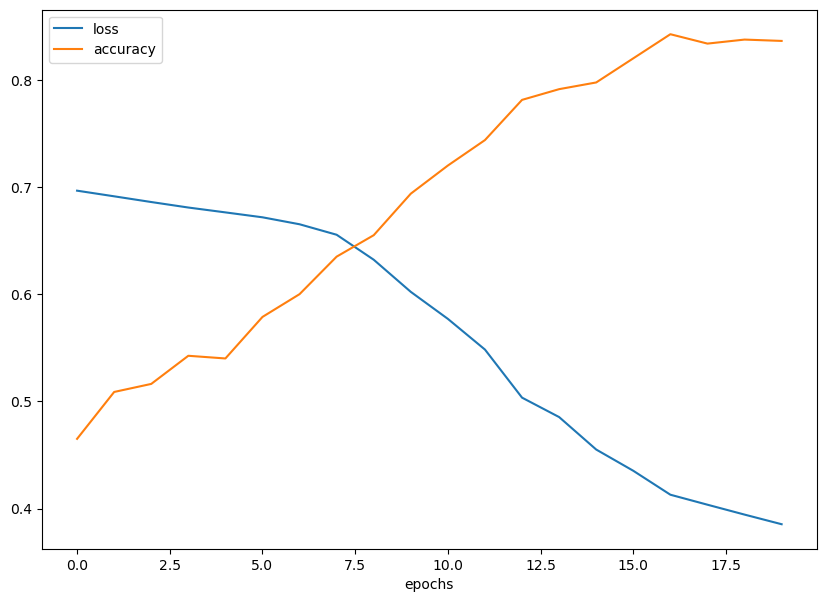

In [32]:
pd.DataFrame(history_11.history).plot(figsize=(10, 7), xlabel="epochs")

In [33]:
# Evaluate
model_11.evaluate(X_test, y_test)

7/7 [==============================] - 0s 1ms/step - loss: 0.3800 - accuracy: 0.8550


[0.3799596130847931, 0.8550000190734863]

In [34]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 6175), started 0:00:59 ago. (Use '!kill 6175' to kill it.)

313/313 [==============================] - 0s 804us/step
doing binary classifcation...
313/313 [==============================] - 0s 658us/step
doing binary classifcation...


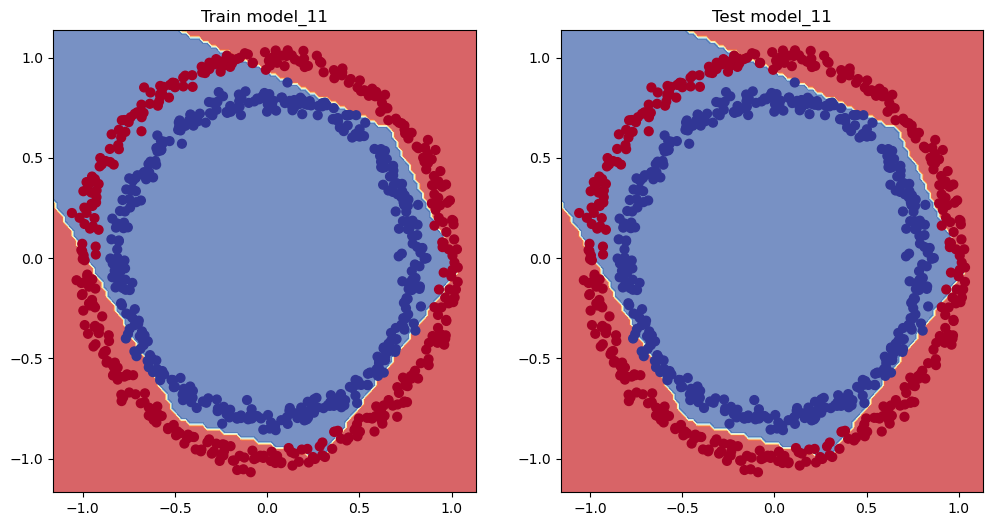

In [35]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train model_11")
plot_decision_boundary(model_11, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test model_11")
plot_decision_boundary(model_11, X=X_train, y=y_train)

313/313 [==============================] - 0s 672us/step
doing binary classifcation...
313/313 [==============================] - 0s 654us/step
doing binary classifcation...


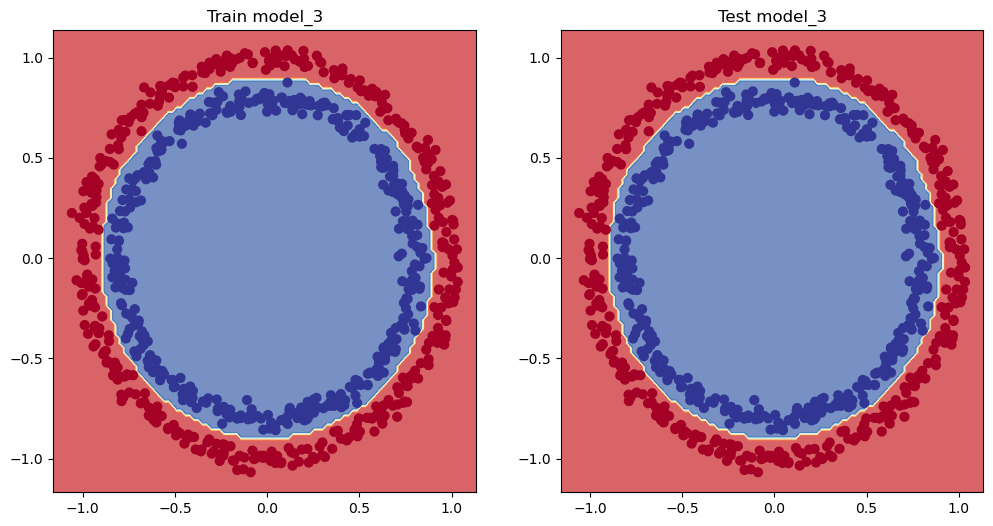

In [36]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train model_3")
plot_decision_boundary(loaded_model_3, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test model_3")
plot_decision_boundary(loaded_model_3, X=X_train, y=y_train)

## More classification evaluation methods

Alongside visualizing our models results as much as possible, there are a  handful of other classfication evaluation methods & metrics you should be familiar with:
* Accuracy
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report (from scikit-learn)

In [37]:
# Check the accuracy of our model
loss, accuracy = model_11.evaluate(X_test, y_test)
print(f"Model loss on the test set: {loss}")
print(f"Model accuracy on the test set: {(accuracy*100):.2f}%")

7/7 [==============================] - 0s 1ms/step - loss: 0.3800 - accuracy: 0.8550
Model loss on the test set: 0.3799596130847931
Model accuracy on the test set: 85.50%


How about a confusion matrix?

In [38]:
y_preds = model_11.predict(X_test)
y_preds

7/7 [==============================] - 0s 833us/step


array([[0.7430419 ],
       [0.8740482 ],
       [0.707672  ],
       [0.67891574],
       [0.09856999],
       [0.6828685 ],
       [0.7877109 ],
       [0.730885  ],
       [0.8770967 ],
       [0.07377334],
       [0.81939715],
       [0.7612937 ],
       [0.7558467 ],
       [0.9126941 ],
       [0.81550753],
       [0.76487195],
       [0.62025243],
       [0.72778434],
       [0.02392291],
       [0.720216  ],
       [0.68469715],
       [0.71219295],
       [0.7086265 ],
       [0.7928237 ],
       [0.05820966],
       [0.72990036],
       [0.91222507],
       [0.7595571 ],
       [0.32470995],
       [0.6816936 ],
       [0.54362977],
       [0.68656653],
       [0.757603  ],
       [0.72358394],
       [0.7574047 ],
       [0.6891317 ],
       [0.73490083],
       [0.6222509 ],
       [0.72008836],
       [0.7270981 ],
       [0.7853437 ],
       [0.7361989 ],
       [0.7928237 ],
       [0.01125609],
       [0.6914121 ],
       [0.74026155],
       [0.711342  ],
       [0.256

In [39]:
y_preds = tf.math.sigmoid(y_preds)
y_preds

<tf.Tensor: shape=(200, 1), dtype=float32, numpy=
array([[0.67766064],
       [0.7055873 ],
       [0.6698865 ],
       [0.6634966 ],
       [0.52462256],
       [0.6643786 ],
       [0.6873396 ],
       [0.6749995 ],
       [0.7062202 ],
       [0.51843494],
       [0.69410837],
       [0.68163455],
       [0.68045133],
       [0.71355116],
       [0.6932819 ],
       [0.68241054],
       [0.65027595],
       [0.6743189 ],
       [0.50598043],
       [0.67265457],
       [0.6647863 ],
       [0.67088556],
       [0.6700976 ],
       [0.6884373 ],
       [0.5145483 ],
       [0.6747834 ],
       [0.71345526],
       [0.68125755],
       [0.58047163],
       [0.6641166 ],
       [0.6326564 ],
       [0.66520274],
       [0.6808331 ],
       [0.67339575],
       [0.68079   ],
       [0.66577375],
       [0.6758798 ],
       [0.6507303 ],
       [0.6726265 ],
       [0.67416817],
       [0.68683064],
       [0.6761641 ],
       [0.6884373 ],
       [0.502814  ],
       [0.6662809 ],
     

In [40]:
tf.round(y_preds)[:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)>

In [41]:
confusion_matrix(y_test, tf.round(y_preds))

array([[  0, 101],
       [  0,  99]])

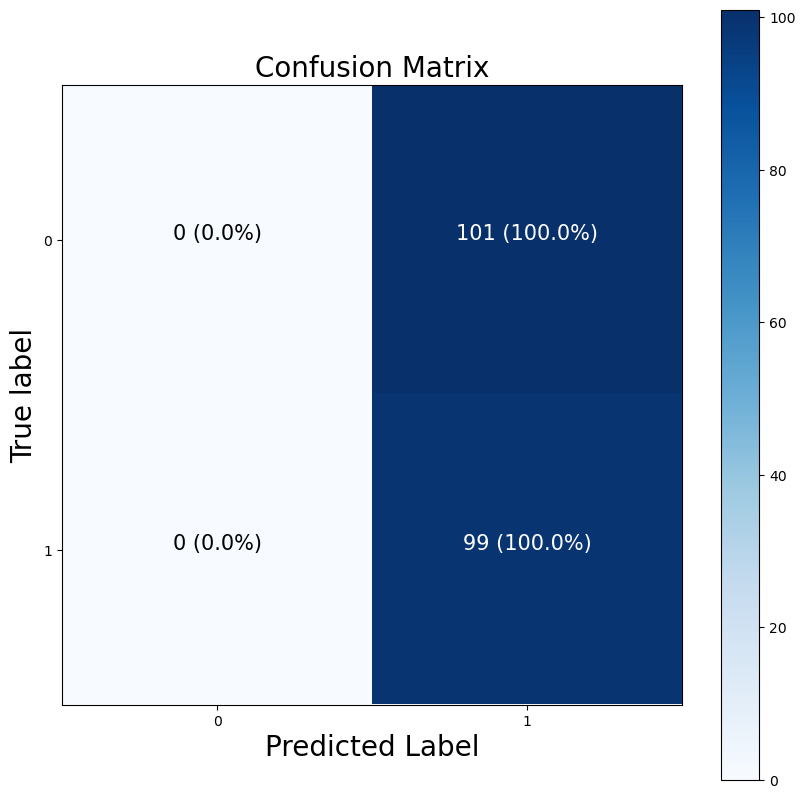

In [48]:
figsize = (10, 10)

# Create the confusion matrix
cm = confusion_matrix(y_test, tf.round(y_preds))
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize our confusion matrix
n_classes = cm.shape[0]

# Let's prettify it
fig, ax = plt.subplots(figsize=figsize)
# Create a matrix plot
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

# Create classes
classes = False

if classes:
    labels = classes
else:
    labels = np.arange(cm.shape[0])  # np.arrange Return evenly spaced values within a given interval.
    
# Label the axes
ax.set(title="Confusion Matrix",
      xlabel="Predicted Label",
      ylabel="True label",
      xticks=np.arange(n_classes),
      yticks=np.arange(n_classes),
      xticklabels=labels,
      yticklabels=labels)

# Set x-axis labels to bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Adjust label size
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)
ax.title.set_size(20)

# Set threshold fo different colors
threshold = (cm.max() + cm.min()) / 2.

# Plot the text on each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
            horizontalalignment="center",
            color="white" if cm[i, j] > threshold else "black",
            size=15)

# Working with a larger example(multi-class classification)

When ou have more than two classes as an optin, it's known as **multi-class classification**.
* This means if you have 3 difrenretclasses, it's multiclass classification.
* It also means if you have 100 different classes, it's multi-class classification.

To pracice multi-class classification, we're going to build a neural network to classify images of differnet

In [66]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import random

# The data has already been sorted into training and test sets for us
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

In [51]:
# Show the first training example
print(f"Training sample:\n{train_data[0]}\n")
print(f"Training label:\n{train_labels[0]}\n")

Training sample:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1  

In [53]:
# Check the shape of a single example
train_data[0].shape, train_labels[0].shape

((28, 28), ())

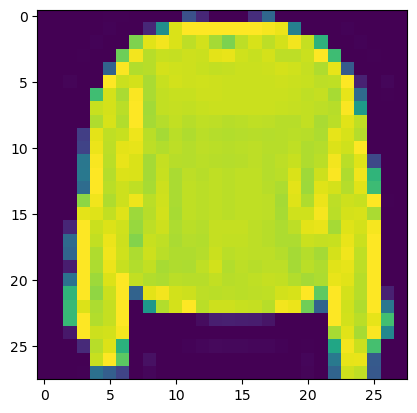

In [60]:
# PLot a single sample
plt.imshow(train_data[7]);

In [61]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# How many classes are there (this'll be our output shape)?
len(class_names)
     

10

Text(0.5, 1.0, 'T-shirt/top')

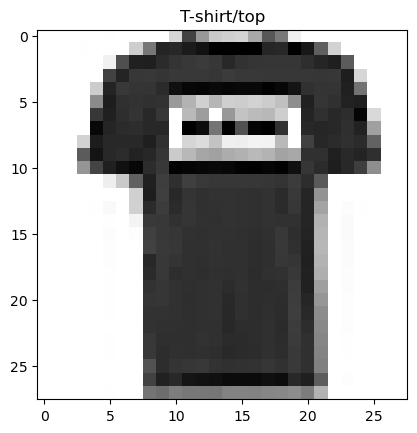

In [65]:
# Plot an example image and its label
index_of_choice = 1
plt.imshow(train_data[index_of_choice], cmap=plt.cm.binary)
plt.title(class_names[train_labels[index_of_choice]])

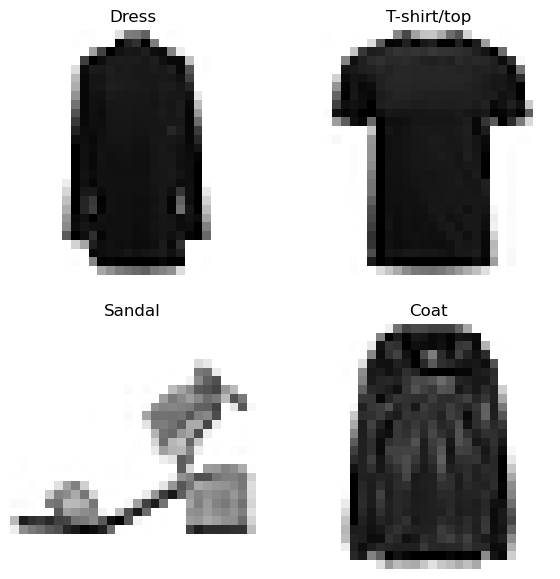

In [76]:
# Plot multiple random images of fashion MNIST
plt.figure(figsize=(7, 7))
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    rand_index = random.choice(range(len(train_data)))
    plt.imshow(train_data[rand_index], cmap=plt.cm.binary)
    plt.title(class_names[train_labels[rand_index]])
    plt.axis(False)

## Building a multi-class classification model